# Quantum Machine Learning

In this tutorial, we'll use a combination quantum-classical algorithm in order to train a model to predict data points in a curve. 

We start out by importing all of the necessary python packages, including PennyLane to build the quantum circuit, matplotlib to visualize our data, and Covalent to organize, track, and dispatch our workflow.

In [1]:
import pennylane as qml
from pennylane import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import covalent as ct

We'll start out by loading our data from a csv file. In this example, we use a gaussian curve, but any simple curve could be used.

In [2]:
@ct.electron
def load_data(filename):
    data = pd.read_csv(filename)
    return data

In [3]:
data = load_data('gaussian.csv')
print(len(data))

600


As is, the dataset is too large! Quantum circuits function best with smaller datasets, so we define a new function to evenly select datapoints from our csv file. The below function, reduce_data, takes the dataset and number of data points n. We choose 7 data points, but we encourage the user to vary this number and see how it impacts the algorithm's performance.

In [4]:
@ct.electron
def reduce_data(data, n):
    interval = int(len(data)/n)
    return data.iloc[::interval, :]


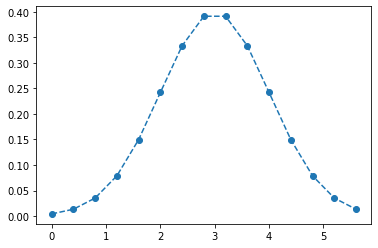

In [5]:
red_data = reduce_data(data, 15)
plt.scatter(red_data['X'], red_data['Y'])
plt.plot(red_data['X'], red_data['Y'], linestyle='--')
plt.show()

The process of validation is an important part of machine learning. Validation involves separating your dataset into separate training and testing datasets. The training dataset is used to actually train the parameters of your model. Once your model has been sufficiently trained, its accuracy can be evaluated using the test dataset. The majority of the original dataset (usually 60-85%) is used for training data, while the remaining data (15-40%) is used for test data.

In the following step, we split our reduced dataset into training and test data, and separate the X and Y columns. There are a few ways to do this, but in this example we'll use scikit-learn's train_test_split() function. 

In [6]:
@ct.electron
def train_test_split(data, train_portion):
    from sklearn.model_selection import train_test_split
    X_train, X_test, Y_train, Y_test = train_test_split(data['X'], data['Y'], train_size=train_portion, random_state=42)
    X_train.requires_grad = False
    return np.tensor(X_train), np.array(Y_train), np.tensor(X_test), np.array(Y_test)

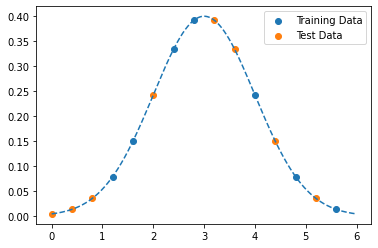

In [7]:
X_train, Y_train, X_test, Y_test = train_test_split(red_data, 0.5)

plt.plot(data['X'], data['Y'], linestyle='--')
plt.scatter(X_train, Y_train, label='Training Data')
plt.scatter(X_test, Y_test, label='Test Data')
plt.legend()
plt.show()

In [8]:
print(X_train)

[5.6 1.6 2.8 4.  4.8 1.2 2.4]


In [9]:
#@ct.electron
def create_data(n):
    from scipy.stats import norm
    X_train = np.arange(0, 6, 0.5)
    X_train.requires_grad = False
    Y_train = norm.pdf(X_train,3,1)
    X_test = np.arange(1, 7, 0.5)
    Y_test = norm.pdf(X_train,3,1)
    return X_train, Y_train, X_test, Y_test

In [10]:
print(create_data(6))

(tensor([0. , 0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. , 5.5], requires_grad=False), array([0.00443185, 0.0175283 , 0.05399097, 0.1295176 , 0.24197072,
       0.35206533, 0.39894228, 0.35206533, 0.24197072, 0.1295176 ,
       0.05399097, 0.0175283 ]), tensor([1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. , 5.5, 6. , 6.5], requires_grad=True), array([0.00443185, 0.0175283 , 0.05399097, 0.1295176 , 0.24197072,
       0.35206533, 0.39894228, 0.35206533, 0.24197072, 0.1295176 ,
       0.05399097, 0.0175283 ]))


In [11]:
@ct.electron
def plot_data(X_train, Y_train, X_test, Y_test):
    plt.scatter(X_train, Y_train, color='#219ebc', label='Training Data')
    plt.scatter(X_test, Y_test, color='#fb8500', alpha=0.5, label='Test Data')
    plt.legend()
    plt.savefig('input_data.png')

In [12]:
dev = qml.device('default.qubit', wires=1)
@qml.qnode(dev)
def quantum_circuit(datapoint, params):
        qml.RX(datapoint, wires=0)
        qml.Rot(params[0], params[1], params[2], wires=0)
        return qml.expval(qml.PauliZ(wires=0))

In [13]:
@ct.electron
def cost_fn(params):
    X, Y, X_test, Y_test = train_test_split(red_data, 0.5)
    predictions = [quantum_circuit(x, params)  for x in X]
    cost = loss_func(predictions)
    return cost
    
@ct.electron
def gradient_descent(X):
    opt = qml.GradientDescentOptimizer(stepsize=0.3)
    params = np.array([0.1,0.1,0.1],requires_grad=True)
    for i in range (100):
        # Over each step the parameters change to give a better cost
        params, prev_cost = opt.step_and_cost(cost_fn,params) 
        if i%10 == 0:
             # We print the result after every 10 steps
            print(f'Step = {i} Cost = {cost_fn(params)}')
    return params

In [14]:
@ct.electron
def make_predictions(X_test, params):
    test_predictions = []
    for x_test in X_test:
        prediction = quantum_circuit(x_test,params)
        test_predictions.append(prediction)
    return test_predictions

In [15]:
@ct.electron
def loss_func(predictions):
    X, Y, X_test, Y_test = train_test_split(red_data, 0.5)
    # This is a postprocessing step. Here we use a least squares metric 
    # based on the predictions of the quantum circuit and the outputs 
    # of the training data points.
    total_losses = 0
    for i in range(len(Y)):
        output = Y[i]
        prediction = predictions[i]
        loss = (prediction - output)**2
        total_losses += loss
    return total_losses

In [16]:
@ct.electron
def plot_results(X, Y, X_test, Y_test, predictions):
    fig = plt.figure()
    ax1 = fig.add_subplot(111)
    ax1.plot(X, Y, c='#219ebc', label='Training data')
    ax1.plot(X_test,Y_test, c='#fb8500', label='Test data')
    ax1.scatter(X_test,predictions, s=30, c='k', marker="x", label='Model Predicitons')
    plt.xlabel("Inputs")
    plt.ylabel("Outputs")
    plt.title("QML results")
    plt.legend(loc='upper right')
    plt.savefig('predictions.png')

Before we finally define our lattice, let's review all of our electrons.

In [17]:
@ct.lattice
def workflow():
    X, Y, X_test, Y_test = train_test_split(red_data, 0.5)
    plot_data(X, Y, X_test, Y_test)
    params = gradient_descent(X=X)
    predictions = make_predictions(X_test=X_test, params=params)
    loss_func(predictions)
    plot_results(X, Y, X_test, Y_test, predictions)

In [18]:
#workflow.draw()

In [19]:
#ct.dispatch(workflow)()

Step = 0 Cost = 4.244323098254797
Step = 10 Cost = 0.9980501858419922
Step = 20 Cost = 0.9388578142487743
Step = 30 Cost = 0.9411925201153004
Step = 40 Cost = 0.9411989221962953
Step = 50 Cost = 0.9411961401594526
Step = 60 Cost = 0.9411962070326276
Step = 70 Cost = 0.9411962083684737
Step = 80 Cost = 0.9411962082580264
Step = 90 Cost = 0.9411962082594703
None


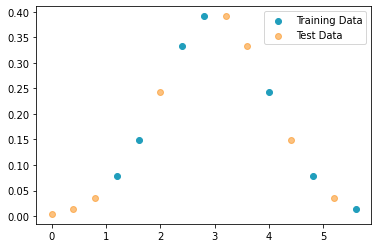

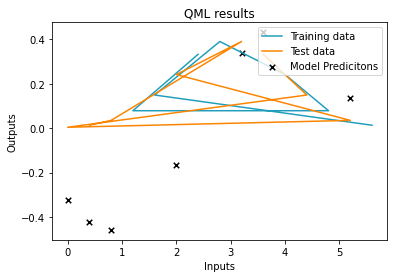

In [20]:
params = workflow()
print(params)